<a href="https://colab.research.google.com/github/DUbennett/analysis/blob/main/Tweet_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Twitter Analysis Using NLP


# Background
In two homework labs this quarter, we used the Twitter API as nominal use cases to explore REST APIs and data cleaning strategies. After learning about NLP, I wanted to discover more of what is possible. I came across the John Snow Labs while search for NLP libraries. Aside from a cool name, they have pretraind Natural Languageon Understanding (NLU) libraries purpose build for Python. The libraries are built on Spark's NLP text processing.

# Motivation
The NLP and NLU space is rapidly evolving and becoming more competitive. Companies and open source groups are making models more powerful while simultaneously becoming easier to use. Just this week, OpenAi's GTP3 language prediction model became available to general public.

The goal of this notebook is to analyze the sentiment of Tweets for a given search term using machine learning algorithms. This notebook serves as lightweight proof of concept for a program that could monitor Tweets in real-time. Many similar commercial products exist that monitor Twitter to identify overall brand sentiment, changes in sentiment, and potential customer facing issues. 

# Dataset
The notbook leverages the Twitter API called used in Homework 4 with some small modifications. Data is collected when the notebook is run. 



*Side Note:*
Sunday morning I fumbled my phone on the screen of my MacBook Pro and cracked the screen. Most of my coding work was complete. But I had not learned the lessions of this very class and my code to GitHub. My computer was functional using a second screen. Unfortunately, I stepped away for a few hours and my computer went to sleep -- aparently forever. The computer will only go to recovery mode and I can no longer log-in. GitHub lesson learned.

After panicking for a few hours, I tried Google CoLab and made it work. I did have to rewrite all of my code and analysis.

In [68]:
# Variables for use in notebook
max_tweets_to_get = 2000
search_term = 'kyle rittenhouse'

In [2]:
import os
os.getcwd()

'/content'

## Environment Set-Up

In [3]:
# Set-up Colab Environment to use John Snow Lab NLU
!wget https://setup.johnsnowlabs.com/nlu/colab.sh -O - | bash
import os
! apt-get update -qq > /dev/null   
# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

--2021-11-22 10:15:28--  https://setup.johnsnowlabs.com/nlu/colab.sh
Resolving setup.johnsnowlabs.com (setup.johnsnowlabs.com)... 51.158.130.125
Connecting to setup.johnsnowlabs.com (setup.johnsnowlabs.com)|51.158.130.125|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://raw.githubusercontent.com/JohnSnowLabs/nlu/master/scripts/colab_setup.sh [following]
--2021-11-22 10:15:30--  https://raw.githubusercontent.com/JohnSnowLabs/nlu/master/scripts/colab_setup.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1662 (1.6K) [text/plain]
Saving to: ‘STDOUT’

-                   100%[===================>]   1.62K  --.-KB/s    in 0s      

2021-11-22 10:15:31 (47.8 MB/s) - written to stdout [1662/1662]

Installing  NLU 

In [4]:
# Install packages in environment
! pip install nlu pyspark
! pip install pandas
! pip install seaborn
! pip install matplotlib
! pip install emoji
! pip install numpy
! pip install sklearn
! pip install contractions

     |████████████████████████████████| 170 kB 4.1 MB/s 
  Created wheel for emoji: filename=emoji-1.6.1-py3-none-any.whl size=169314 sha256=0a5d98b8b494216adda82011c5ae823ba32020dd648e6d8ecb5cf0c07e64189b
  Stored in directory: /root/.cache/pip/wheels/ea/5f/d3/03d313ddb3c2a1a427bb4690f1621eea60fe6f2a30cc95940f
Successfully built emoji
     |████████████████████████████████| 284 kB 4.2 MB/s 
     |████████████████████████████████| 321 kB 54.9 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85454 sha256=470dec6f97ad79b57646627b84250f76d3d66ee78df855629ac450a016263c33
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [63]:
# Import libraries
import nlu
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import emoji
import numpy as np
import contractions
import re
import pickle
from datetime import datetime
plt.rcParams['figure.figsize'] = [16, 9]

In [6]:
# Pipelines are set-up and called as needed
# Set-up NLU pipelines
# TAKES A LONG TIME!!!!!!
# sentiment = nlu.load('sentiment')
# emotion = nlu.load('emotion')
# spell = nlu.load('spell')
# fakeNews = nlu.load('en.classify.fakenews')
# spam = nlu.load('en.classify.spam')
# toxic = nlu.load('en.classify.toxic')
# twitterSentiment = nlu.load('en.sentiment.twitter')
# sarcasm = nlu.load('en.classify.sarcasm')
# yake = nlu.load('yake')

## Helper Functions

In [7]:
# Create helper functions

def cleanText(text):
    # r'(@\w+)' removes handles
    # r'https?://\S+|www\.\S+' removes web links
    # r'\R' removes new lines
    # r'[^a-zA-Z0-9_ ] removes punctuation

    text = str(text)
    text = emoji.demojize(text)
    text = contractions.fix(text)
    text = re.sub(r'(@\w+)|\\R', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'(RT)', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9 \.]', ' ', text)
    text = " ".join(text.split())
    return text.strip()

def finalTweet(row):
    if row['truncated'] == False:
        return row['text']
    elif row['truncated'] == False and row['full_text'] == np.NaN:
        return row['text']
    else:
        return row['full_text']

def time_scale(df):
  min = df['created_at'].min()
  max = df['created_at'].max()
  time_range = max - min
  if time_range.seconds <= 60:
    return 'S'
  elif time_range.seconds in range(6 ,3600):
    return ('min', 'Minute')
  elif time_range.seconds in range(3600, 86400):
    return ('H', 'Hour')
  elif time_range.days in range (1,28):
    return ('D', 'Days')
  elif time_range.days in range (28, 180):
    return ('W', 'Week')
  elif time_range.days in range (180,730):
    return ('M', 'Month')
  else:
    return ('Y', 'Year')

## Twitter Auth Set-Up

In [8]:
# Set-up Twitter Auths
client_key = 'qkuKRLkpbjSHpv6IDzCYg0iEn'
client_secret =  'wtYgaslqr4OWRaEjVWlzez7LVqzg8yxTv54IqdWSDoHzuxiAjy'
import requests
import base64

key_secret = '{}:{}'.format(client_key, client_secret).encode('ascii')
b64_encoded_key = base64.b64encode(key_secret)
b64_encoded_key = b64_encoded_key.decode('ascii')
base_url = 'https://api.twitter.com/'
auth_endpoint = base_url+'oauth2/token'

auth_headers = { 'Authorization': 'Basic {}'.format(b64_encoded_key),
                'Content-Type': 'application/x-www-form-urlencoded;charset=UTF-8'}

auth_data = { 'grant_type': 'client_credentials'}

response = requests.post(auth_endpoint, headers=auth_headers, data=auth_data)
response.status_code
json_data =  response.json()
# json_data
access_token = json_data['access_token']

## Collect Tweets

In [9]:
## Get tweet text (regular length tweets)
max_tweets=max_tweets_to_get
tw_limit=100# we can get only 100 tweet per call with standard search api
tweets = []
search_headers = {'Authorization': 'Bearer {}'.format(access_token)    
}

parameters = { 'q': search_term,
                    'result_type': 'recent',
                    'lang': 'en',
                    # 'tweet_mode': 'extended',
                    'count': 100 }

search_url = base_url+'1.1/search/tweets.json'

response = requests.get(search_url, headers=search_headers, params=parameters)
search_tweets = response.json()
len(search_tweets['statuses'])
tweets +=search_tweets['statuses']
ids = [tw['id'] for tw in search_tweets['statuses']]
min_id = min(ids)
tw_ids = []
tw_ids+=ids
for  i in range(max_tweets//tw_limit -1):
    parameters = { 'q': search_term,
                    'result_type': 'recent',
                'count': tw_limit,
                'max_id': min_id
                 }
    print("searching tweets with id  < {}".format(min_id))
    search_url = base_url+'1.1/search/tweets.json'
    response = requests.get(search_url, headers=search_headers, params=parameters)
    search_tweets = response.json()
    ids = [tw['id'] for tw in search_tweets['statuses']]
    tw_ids+=ids
    print(i, len(search_tweets['statuses']))
    min_id = min(ids)
    tweets +=search_tweets['statuses']
    print('Total tweets retrieved= {}'.format(len(tweets)))


searching tweets with id  < 1462726244638855171
0 92
Total tweets retrieved= 189
searching tweets with id  < 1462725515458998272
1 91
Total tweets retrieved= 280
searching tweets with id  < 1462724935634272257
2 89
Total tweets retrieved= 369
searching tweets with id  < 1462724345722245125
3 100
Total tweets retrieved= 469


In [10]:
## Get extended text (text of truncated tweets)
max_tweets=max_tweets_to_get
tw_limit=100# we can get only 100 tweet per call with standard search api
tweets2 = []
search_headers = {'Authorization': 'Bearer {}'.format(access_token)    
}

parameters = { 'q': search_term,
                    'result_type': 'recent',
                    'lang': 'en',
                    'tweet_mode': 'extended',
                    'count': 100 }

search_url = base_url+'1.1/search/tweets.json'

response = requests.get(search_url, headers=search_headers, params=parameters)
search_tweets2 = response.json()
len(search_tweets2['statuses'])
tweets2 +=search_tweets2['statuses']
ids = [tw['id'] for tw in search_tweets2['statuses']]
min_id = min(ids)
tw_ids = []
tw_ids+=ids
for  i in range(max_tweets//tw_limit -1):
    parameters = { 'q': search_term,
                    'result_type': 'recent',
                'count': tw_limit,
                'max_id': min_id
                 }
    print("searching tweets with id  < {}".format(min_id))
    search_url = base_url+'1.1/search/tweets.json'
    response = requests.get(search_url, headers=search_headers, params=parameters)
    search_tweets2 = response.json()
    ids = [tw['id'] for tw in search_tweets2['statuses']]
    tw_ids+=ids
    print(i, len(search_tweets2['statuses']))
    min_id = min(ids)
    tweets2 +=search_tweets2['statuses']
    print('Total tweets retrieved= {}'.format(len(tweets)))

searching tweets with id  < 1462726263341293571
0 93
Total tweets retrieved= 469
searching tweets with id  < 1462725547218325512
1 90
Total tweets retrieved= 469
searching tweets with id  < 1462724960636616704
2 88
Total tweets retrieved= 469
searching tweets with id  < 1462724381956739084
3 100
Total tweets retrieved= 469


In [11]:
# Create dfs for collected tweets
tweets_df = pd.DataFrame(tweets)
tweets_df2 = pd.DataFrame(tweets2)
# Clean-up the full text tweets df by dropping columns that aren't needed and NAs
tweets_df2 = tweets_df2[['id', 'full_text']].dropna()

In [12]:
tweets_df

,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,retweeted_status,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,quoted_status_id,quoted_status_id_str,extended_entities,quoted_status
0,Mon Nov 22 10:17:34 +0000 2021,1462726946740224000,1462726946740224000,"RT @cooltxchick: I don’t know about you, but f...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,None,NaN,None,None,"{'id': 1176668927407079426, 'id_str': '1176668...",None,None,None,None,{'created_at': 'Mon Nov 22 03:09:44 +0000 2021...,False,342,0,False,False,en,NaN,NaN,NaN,NaN,NaN
1,Mon Nov 22 10:17:30 +0000 2021,1462726928276856835,1462726928276856835,RT @asymmetricinfo: The number of people outra...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,None,NaN,None,None,"{'id': 974815014673682432, 'id_str': '97481501...",None,None,None,None,{'created_at': 'Sun Nov 21 17:46:31 +0000 2021...,False,763,0,False,False,en,NaN,NaN,NaN,NaN,NaN
2,Mon Nov 22 10:17:28 +0000 2021,1462726921704198148,1462726921704198148,RT @ChuckCallesto: BREAKING REPORT: Defamation...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 913784599049682944, 'id_str': '91378459...",None,None,None,None,{'created_at': 'Sun Nov 21 16:27:42 +0000 2021...,False,2524,0,False,False,en,NaN,NaN,NaN,NaN,NaN
3,Mon Nov 22 10:17:28 +0000 2021,1462726921280798722,1462726921280798722,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,False,"{'hashtags': [{'text': 'Rittenhouse', 'indices...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 53231656, 'id_str': '53231656', 'name':...",None,None,None,None,{'created_at': 'Sun Nov 21 22:58:18 +0000 2021...,False,446,0,False,False,en,NaN,NaN,NaN,NaN,NaN
4,Mon Nov 22 10:17:27 +0000 2021,1462726916444762112,1462726916444762112,"RT @gavinesler: My take on ""Missing the point ...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,None,NaN,None,None,"{'id': 175422117, 'id_str': '175422117', 'name...",None,None,None,None,{'created_at': 'Sun Nov 21 16:27:39 +0000 2021...,False,19,0,False,False,en,False,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,Mon Nov 22 10:04:46 +0000 2021,1462723723111378948,1462723723111378948,RT @AlejandroSBasso: #ULTIMAHORA \n\nDepartame...,False,"{'hashtags': [{'text': 'ULTIMAHORA', 'indices'...","{'iso_language_code': 'es', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,None,NaN,None,None,"{'id': 2366065399, 'id_str': '2366065399', 'na...",None,None,None,None,{'created_at': 'Sun Nov 21 17:47:47 +0000 2021...,False,164,0,False,False,es,NaN,NaN,NaN,NaN,NaN
465,Mon Nov 22 10:04:45 +0000 2021,1462723718002716672,1462723718002716672,"RT @cooltxchick: I don’t know about you, but f...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,None,NaN,None,None,"{'id': 171198826, 'id_str': '171198826', 'name...",None,None,None,None,{'created_at': 'Mon Nov 22 03:09:44 +0000 2021...,False,342,0,False,False,en,NaN,NaN,NaN,NaN,NaN
466,Mon Nov 22 10:04:43 +0000 2021,1462723710675140612,1462723710675140612,RT @DailyMail: NICHOLAS SANDMANN: The c

In [13]:
tweets_df2

,id,full_text
0,1462726968839913472,"Kyle Rittenhouse says he supports BLM, case wa..."
1,1462726962678538240,RT @itsJeffTiedrich: it's lucky for Kyle Ritte...
2,1462726959016910850,RT @cathyyoung421: Democrat police chief fired...
3,1462726946740224000,"RT @cooltxchick: I don’t know about you, but f..."
4,1462726928276856835,RT @asymmetricinfo: The number of people outra...
...,...,...
90,1462726292349063170,RT @JackPosobiec: Go watch the Crossfire segme...
91,1462726286623879171,Imagine seeing online that a car drove over ch...
92,1462726272635703300,RT @SkyNewsAust: Sky News host @RitaPanahi say...
93,1462726272186945537,RT @lilaaron911: kyle rittenhouse can suck my ...


## Data Clean-up & DType Fixing

In [14]:
# Merge dfs to get text and full text
tweets_df = tweets_df.merge(tweets_df2, how = 'left', left_on = 'id', right_on='id' )
tweets_df['tweet_text'] = tweets_df.apply(finalTweet, axis=1)
tweets_df

,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,in_reply_to_screen_name,user,geo,coordinates,place,contributors,retweeted_status,is_quote_status,retweet_count,favorite_count,favorited,retweeted,lang,possibly_sensitive,quoted_status_id,quoted_status_id_str,extended_entities,quoted_status,full_text,tweet_text
0,Mon Nov 22 10:17:34 +0000 2021,1462726946740224000,1462726946740224000,"RT @cooltxchick: I don’t know about you, but f...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,None,NaN,None,None,"{'id': 1176668927407079426, 'id_str': '1176668...",None,None,None,None,{'created_at': 'Mon Nov 22 03:09:44 +0000 2021...,False,342,0,False,False,en,NaN,NaN,NaN,NaN,NaN,"RT @cooltxchick: I don’t know about you, but f...","RT @cooltxchick: I don’t know about you, but f..."
1,Mon Nov 22 10:17:30 +0000 2021,1462726928276856835,1462726928276856835,RT @asymmetricinfo: The number of people outra...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,None,NaN,None,None,"{'id': 974815014673682432, 'id_str': '97481501...",None,None,None,None,{'created_at': 'Sun Nov 21 17:46:31 +0000 2021...,False,763,0,False,False,en,NaN,NaN,NaN,NaN,NaN,RT @asymmetricinfo: The number of people outra...,RT @asymmetricinfo: The number of people outra...
2,Mon Nov 22 10:17:28 +0000 2021,1462726921704198148,1462726921704198148,RT @ChuckCallesto: BREAKING REPORT: Defamation...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 913784599049682944, 'id_str': '91378459...",None,None,None,None,{'created_at': 'Sun Nov 21 16:27:42 +0000 2021...,False,2524,0,False,False,en,NaN,NaN,NaN,NaN,NaN,RT @ChuckCallesto: BREAKING REPORT: Defamation...,RT @ChuckCallesto: BREAKING REPORT: Defamation...
3,Mon Nov 22 10:17:28 +0000 2021,1462726921280798722,1462726921280798722,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,False,"{'hashtags': [{'text': 'Rittenhouse', 'indices...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,None,NaN,None,None,"{'id': 53231656, 'id_str': '53231656', 'name':...",None,None,None,None,{'created_at': 'Sun Nov 21 22:58:18 +0000 2021...,False,446,0,False,False,en,NaN,NaN,NaN,NaN,NaN,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...
4,Mon Nov 22 10:17:27 +0000 2021,1462726916444762112,1462726916444762112,"RT @gavinesler: My take on ""Missing the point ...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,None,NaN,None,None,"{'id': 175422117, 'id_str': '175422117', 'name...",None,None,None,None,{'created_at': 'Sun Nov 21 16:27:39 +0000 2021...,False,19,0,False,False,en,False,NaN,NaN,NaN,NaN,"RT @gavinesler: My take on ""Missing the point ...","RT @gavinesler: My take on ""Missing the point ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,Mon Nov 22 10:04:46 +0000 2021,1462723723111378948,1462723723111378948,RT @AlejandroSBasso: #ULTIMAHORA \n\nDepartame...,False,"{'hashtags': [{'text': 'ULTIMAHORA', 'indices'...","{'iso_language_code': 'es', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,None,NaN,None,None,"{'id': 2366065399, 'id_str': '2366065399', 'na...",None,None,None,None,{'created_at': 'Sun Nov 21 17:47:47 +0000 2021...,False,164,0,False,False,es,NaN,NaN,NaN,NaN,NaN,NaN,RT @AlejandroSBasso: #ULTIMAHORA \n\nDepartame...
465,

In [15]:
# Clean up merged df: remove unused columns, put in better order
tweets_df = tweets_df[['id', 'created_at', 'id_str', 'text', 'full_text', 'tweet_text', 'truncated',  'retweet_count', 'favorited', 'retweeted', 'possibly_sensitive']]
tweets_df.head()


,id,created_at,id_str,text,full_text,tweet_text,truncated,retweet_count,favorited,retweeted,possibly_sensitive
0,1462726946740224000,Mon Nov 22 10:17:34 +0000 2021,1462726946740224000,"RT @cooltxchick: I don’t know about you, but f...","RT @cooltxchick: I don’t know about you, but f...","RT @cooltxchick: I don’t know about you, but f...",False,342,False,False,NaN
1,1462726928276856835,Mon Nov 22 10:17:30 +0000 2021,1462726928276856835,RT @asymmetricinfo: The number of people outra...,RT @asymmetricinfo: The number of people outra...,RT @asymmetricinfo: The number of people outra...,False,763,False,False,NaN
2,1462726921704198148,Mon Nov 22 10:17:28 +0000 2021,1462726921704198148,RT @ChuckCallesto: BREAKING REPORT: Defamation...,RT @ChuckCallesto: BREAKING REPORT: Defamation...,RT @ChuckCallesto: BREAKING REPORT: Defamation...,False,2524,False,False,NaN
3,1462726921280798722,Mon Nov 22 10:17:28 +0000 2021,1462726921280798722,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,False,446,False,False,NaN
4,1462726916444762112,Mon Nov 22 10:17:27 +0000 2021,1462726916444762112,"RT @gavinesler: My take on ""Missing the point ...","RT @gavinesler: My take on ""Missing the point ...","RT @gavinesler: My take on ""Missing the point ...",False,19,False,False,False


In [16]:
# Check dtypes
tweets_df.dtypes

id                     int64
created_at            object
id_str                object
text                  object
full_text             object
tweet_text            object
truncated               bool
retweet_count          int64
favorited               bool
retweeted               bool
possibly_sensitive    object
dtype: object

In [17]:
# See if dtypes can be fixed automatically, 
# I know the datetime conversion won't work, so changing it now
tweets_df = tweets_df.convert_dtypes()
tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'])
tweets_df.dtypes

id                                  Int64
created_at            datetime64[ns, UTC]
id_str                             string
text                               string
full_text                          string
tweet_text                         string
truncated                         boolean
retweet_count                       Int64
favorited                         boolean
retweeted                         boolean
possibly_sensitive                boolean
dtype: object

In [18]:
tweets_df.head()

,id,created_at,id_str,text,full_text,tweet_text,truncated,retweet_count,favorited,retweeted,possibly_sensitive
0,1462726946740224000,2021-11-22 10:17:34+00:00,1462726946740224000,"RT @cooltxchick: I don’t know about you, but f...","RT @cooltxchick: I don’t know about you, but f...","RT @cooltxchick: I don’t know about you, but f...",False,342,False,False,<NA>
1,1462726928276856835,2021-11-22 10:17:30+00:00,1462726928276856835,RT @asymmetricinfo: The number of people outra...,RT @asymmetricinfo: The number of people outra...,RT @asymmetricinfo: The number of people outra...,False,763,False,False,<NA>
2,1462726921704198148,2021-11-22 10:17:28+00:00,1462726921704198148,RT @ChuckCallesto: BREAKING REPORT: Defamation...,RT @ChuckCallesto: BREAKING REPORT: Defamation...,RT @ChuckCallesto: BREAKING REPORT: Defamation...,False,2524,False,False,<NA>
3,1462726921280798722,2021-11-22 10:17:28+00:00,1462726921280798722,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,False,446,False,False,<NA>
4,1462726916444762112,2021-11-22 10:17:27+00:00,1462726916444762112,"RT @gavinesler: My take on ""Missing the point ...","RT @gavinesler: My take on ""Missing the point ...","RT @gavinesler: My take on ""Missing the point ...",False,19,False,False,False


In [19]:
tweets_df['clean_tweet'] = tweets_df['tweet_text'].apply(cleanText)
tweets_df.head()

,id,created_at,id_str,text,full_text,tweet_text,truncated,retweet_count,favorited,retweeted,possibly_sensitive,clean_tweet
0,1462726946740224000,2021-11-22 10:17:34+00:00,1462726946740224000,"RT @cooltxchick: I don’t know about you, but f...","RT @cooltxchick: I don’t know about you, but f...","RT @cooltxchick: I don’t know about you, but f...",False,342,False,False,<NA>,I do not know about you but for me Kyle and hi...
1,1462726928276856835,2021-11-22 10:17:30+00:00,1462726928276856835,RT @asymmetricinfo: The number of people outra...,RT @asymmetricinfo: The number of people outra...,RT @asymmetricinfo: The number of people outra...,False,763,False,False,<NA>,The number of people outraged by the idea that...
2,1462726921704198148,2021-11-22 10:17:28+00:00,1462726921704198148,RT @ChuckCallesto: BREAKING REPORT: Defamation...,RT @ChuckCallesto: BREAKING REPORT: Defamation...,RT @ChuckCallesto: BREAKING REPORT: Defamation...,False,2524,False,False,<NA>,BREAKING REPO Defamation Attorney Todd McMurtr...
3,1462726921280798722,2021-11-22 10:17:28+00:00,1462726921280798722,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,False,446,False,False,<NA>,After Kyle Rittenhouse s verdict was announced...
4,1462726916444762112,2021-11-22 10:17:27+00:00,1462726916444762112,"RT @gavinesler: My take on ""Missing the point ...","RT @gavinesler: My take on ""Missing the point ...","RT @gavinesler: My take on ""Missing the point ...",False,19,False,False,False,My take on Missing the point on Kyle Rittenhou...


## Quick QC Checks

In [20]:
# check some key columns for nans
print('created_at:',tweets_df['created_at'].isna().sum())
print('tweet_text:',tweets_df['tweet_text'].isna().sum())
print('clean_tweet:', tweets_df['clean_tweet'].isna().sum())
print('earliest datetime:', tweets_df['created_at'].min())
print('latest datetime:', tweets_df['created_at'].max())
print((tweets_df['created_at'].max()-tweets_df['created_at'].min()))

created_at: 0
tweet_text: 22
clean_tweet: 0
earliest datetime: 2021-11-22 10:04:36+00:00
latest datetime: 2021-11-22 10:17:34+00:00
0 days 00:12:58


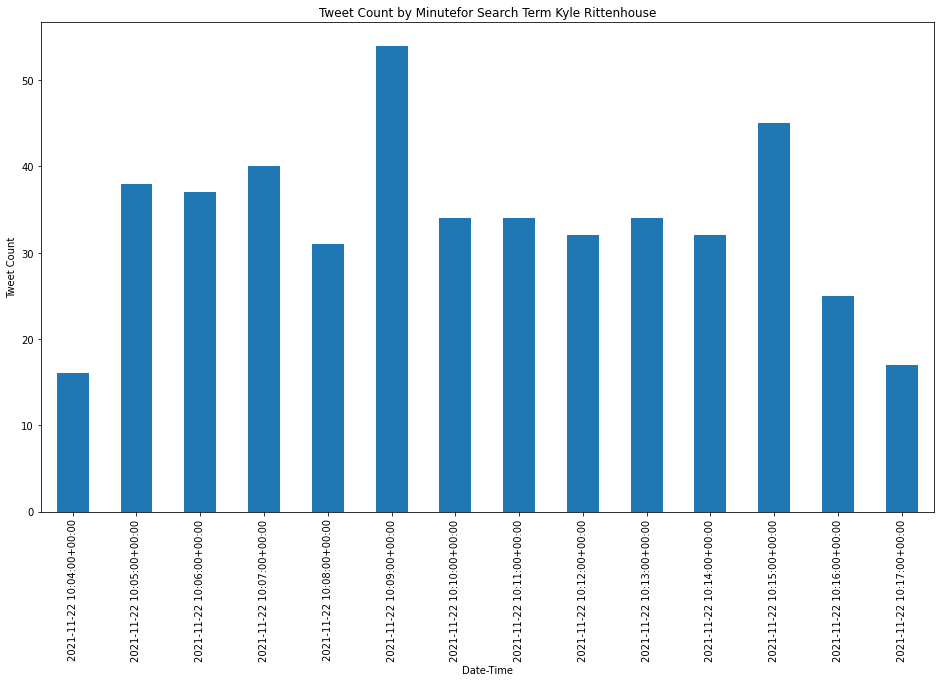

In [21]:
t = time_scale(tweets_df)
tweets_df.groupby([pd.Grouper(key = 'created_at', freq=t[0], axis = 0)]).id_str.count().plot.bar(title =('Tweet Count by ' + t[1]) + 'for Search Term: ' + (search_term).title(), xlabel = 'Date-Time', ylabel = "Tweet Count")

# A, Y =  year end frequency
# M = month end frequency
# W = weekly frequency
# # D = calendar day frequency
# H = hourly frequency
# T, min = minutely frequency
# S = secondly frequency

## Emotion Detection

In [22]:
emotion = nlu.load('emotion')
emo_text = emotion.predict(tweets_df.clean_tweet, output_level='document')
emo_text.head()

classifierdl_use_emotion download started this may take some time.
Approximate size to download 21.3 MB
[OK!]
tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


,document,emotion,emotion_confidence_confidence
0,I do not know about you but for me Kyle and hi...,sadness,1.000000
1,The number of people outraged by the idea that...,surprise,0.999759
2,BREAKING REPO Defamation Attorney Todd McMurtr...,sadness,0.989748
3,After Kyle Rittenhouse s verdict was announced...,surprise,0.999977
4,My take on Missing the point on Kyle Rittenhou...,sadness,0.949577


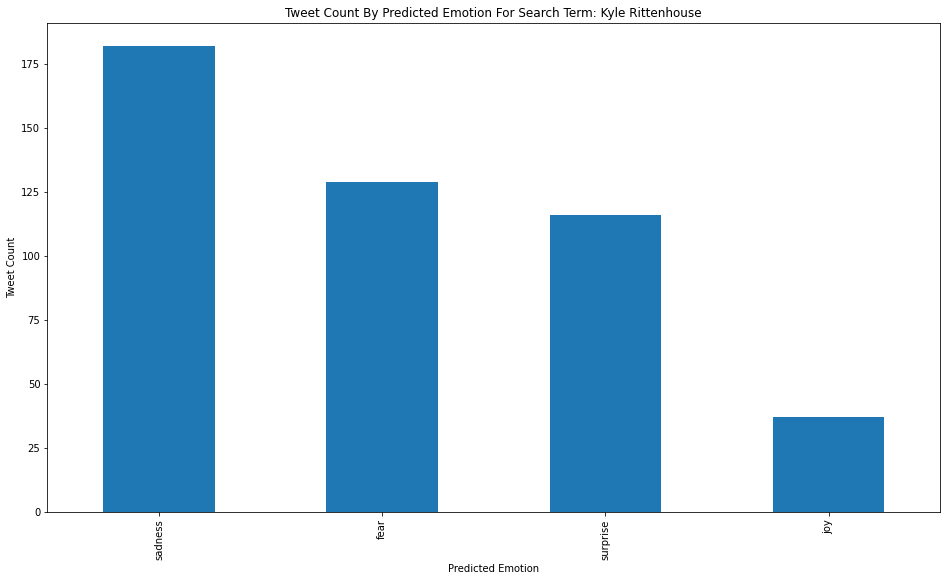

In [23]:
emo_text.emotion.value_counts().plot.bar(title =('Tweet Count by Predicted Emotion for Search Term: ' + search_term).title(), xlabel = 'Predicted Emotion', ylabel = "Tweet Count")

In [24]:
tweets_df = tweets_df.join(emo_text)
tweets_df.drop('document', inplace=True, axis =1)
tweets_df.head()

,id,created_at,id_str,text,full_text,tweet_text,truncated,retweet_count,favorited,retweeted,possibly_sensitive,clean_tweet,emotion,emotion_confidence_confidence
0,1462726946740224000,2021-11-22 10:17:34+00:00,1462726946740224000,"RT @cooltxchick: I don’t know about you, but f...","RT @cooltxchick: I don’t know about you, but f...","RT @cooltxchick: I don’t know about you, but f...",False,342,False,False,<NA>,I do not know about you but for me Kyle and hi...,sadness,1.000000
1,1462726928276856835,2021-11-22 10:17:30+00:00,1462726928276856835,RT @asymmetricinfo: The number of people outra...,RT @asymmetricinfo: The number of people outra...,RT @asymmetricinfo: The number of people outra...,False,763,False,False,<NA>,The number of people outraged by the idea that...,surprise,0.999759
2,1462726921704198148,2021-11-22 10:17:28+00:00,1462726921704198148,RT @ChuckCallesto: BREAKING REPORT: Defamation...,RT @ChuckCallesto: BREAKING REPORT: Defamation...,RT @ChuckCallesto: BREAKING REPORT: Defamation...,False,2524,False,False,<NA>,BREAKING REPO Defamation Attorney Todd McMurtr...,sadness,0.989748
3,1462726921280798722,2021-11-22 10:17:28+00:00,1462726921280798722,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,False,446,False,False,<NA>,After Kyle Rittenhouse s verdict was announced...,surprise,0.999977
4,1462726916444762112,2021-11-22 10:17:27+00:00,1462726916444762112,"RT @gavinesler: My take on ""Missing the point ...","RT @gavinesler: My take on ""Missing the point ...","RT @gavinesler: My take on ""Missing the point ...",False,19,False,False,False,My take on Missing the point on Kyle Rittenhou...,sadness,0.949577


## Sentiment Analysis

In [25]:
sentiment = nlu.load('sentiment')
sentiment_text = sentiment.predict(tweets_df.clean_tweet)
sentiment_text.head()

sentimentdl_glove_imdb download started this may take some time.
Approximate size to download 8.7 MB
[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]
sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


,document,sentiment,sentiment_confidence
0,I do not know about you but for me Kyle and hi...,neutral,0.512305
1,The number of people outraged by the idea that...,pos,0.827644
2,BREAKING REPO Defamation Attorney Todd McMurtr...,neg,0.951887
3,After Kyle Rittenhouse s verdict was announced...,pos,0.999212
4,My take on Missing the point on Kyle Rittenhou...,neg,0.998454


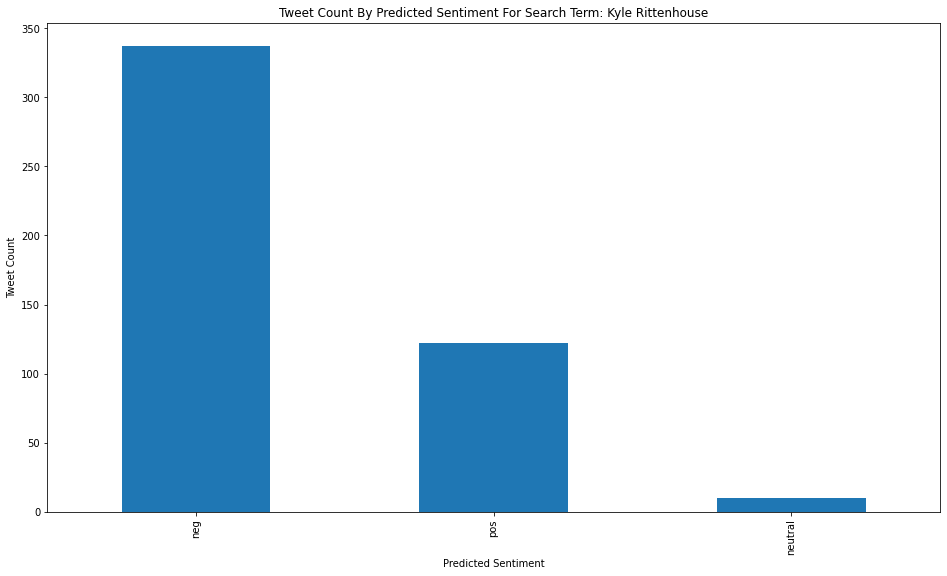

In [26]:
sentiment_text.sentiment.value_counts().plot.bar(title =('Tweet Count by Predicted Sentiment for Search Term: ' + search_term).title(), xlabel = 'Predicted Sentiment', ylabel = "Tweet Count")

In [27]:
tweets_df = tweets_df.join(sentiment_text)
tweets_df.drop('document', inplace=True, axis =1)
tweets_df.head()

,id,created_at,id_str,text,full_text,tweet_text,truncated,retweet_count,favorited,retweeted,possibly_sensitive,clean_tweet,emotion,emotion_confidence_confidence,sentiment,sentiment_confidence
0,1462726946740224000,2021-11-22 10:17:34+00:00,1462726946740224000,"RT @cooltxchick: I don’t know about you, but f...","RT @cooltxchick: I don’t know about you, but f...","RT @cooltxchick: I don’t know about you, but f...",False,342,False,False,<NA>,I do not know about you but for me Kyle and hi...,sadness,1.000000,neutral,0.512305
1,1462726928276856835,2021-11-22 10:17:30+00:00,1462726928276856835,RT @asymmetricinfo: The number of people outra...,RT @asymmetricinfo: The number of people outra...,RT @asymmetricinfo: The number of people outra...,False,763,False,False,<NA>,The number of people outraged by the idea that...,surprise,0.999759,pos,0.827644
2,1462726921704198148,2021-11-22 10:17:28+00:00,1462726921704198148,RT @ChuckCallesto: BREAKING REPORT: Defamation...,RT @ChuckCallesto: BREAKING REPORT: Defamation...,RT @ChuckCallesto: BREAKING REPORT: Defamation...,False,2524,False,False,<NA>,BREAKING REPO Defamation Attorney Todd McMurtr...,sadness,0.989748,neg,0.951887
3,1462726921280798722,2021-11-22 10:17:28+00:00,1462726921280798722,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,False,446,False,False,<NA>,After Kyle Rittenhouse s verdict was announced...,surprise,0.999977,pos,0.999212
4,1462726916444762112,2021-11-22 10:17:27+00:00,1462726916444762112,"RT @gavinesler: My take on ""Missing the point ...","RT @gavinesler: My take on ""Missing the point ...","RT @gavinesler: My take on ""Missing the point ...",False,19,False,False,False,My take on Missing the point on Kyle Rittenhou...,sadness,0.949577,neg,0.998454


## Twitter Trained Sentiment Analysis

In [28]:
# Sentiment Prediction Trained for Twitter
sentiment_twitter = nlu.load('en.sentiment.twitter')
sentiment_twitter_text = sentiment_twitter.predict(tweets_df.clean_tweet)
sentiment_twitter_text.head()

analyze_sentimentdl_use_twitter download started this may take some time.
Approx size to download 935.1 MB
[OK!]
sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


,document,sentiment,sentiment_confidence
0,I do not know about you but for me Kyle and hi...,negative,1.000000
1,The number of people outraged by the idea that...,negative,0.629275
2,BREAKING REPO Defamation Attorney Todd McMurtr...,neutral,0.589265
3,After Kyle Rittenhouse s verdict was announced...,positive,1.000000
4,My take on Missing the point on Kyle Rittenhou...,positive,1.000000


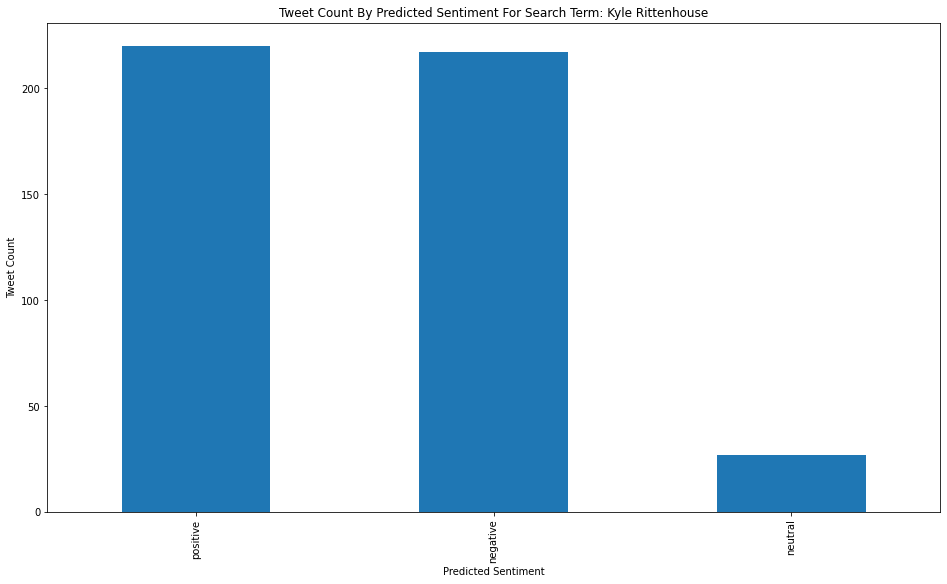

In [29]:
sentiment_twitter_text.sentiment.value_counts().plot.bar(title =('Tweet Count by Predicted Sentiment for Search Term: ' + search_term).title(), xlabel = 'Predicted Sentiment', ylabel = "Tweet Count")

In [30]:
sentiment_twitter_text = sentiment_twitter_text.rename(columns={'sentiment' : 'sentiment_twitter', 'sentiment_confidence': 'sentiment_twitter_confidence'})
tweets_df = tweets_df.join(sentiment_twitter_text)
tweets_df.drop('document', inplace=True, axis =1)
tweets_df.head()

,id,created_at,id_str,text,full_text,tweet_text,truncated,retweet_count,favorited,retweeted,possibly_sensitive,clean_tweet,emotion,emotion_confidence_confidence,sentiment,sentiment_confidence,sentiment_twitter,sentiment_twitter_confidence
0,1462726946740224000,2021-11-22 10:17:34+00:00,1462726946740224000,"RT @cooltxchick: I don’t know about you, but f...","RT @cooltxchick: I don’t know about you, but f...","RT @cooltxchick: I don’t know about you, but f...",False,342,False,False,<NA>,I do not know about you but for me Kyle and hi...,sadness,1.000000,neutral,0.512305,negative,1.000000
1,1462726928276856835,2021-11-22 10:17:30+00:00,1462726928276856835,RT @asymmetricinfo: The number of people outra...,RT @asymmetricinfo: The number of people outra...,RT @asymmetricinfo: The number of people outra...,False,763,False,False,<NA>,The number of people outraged by the idea that...,surprise,0.999759,pos,0.827644,negative,0.629275
2,1462726921704198148,2021-11-22 10:17:28+00:00,1462726921704198148,RT @ChuckCallesto: BREAKING REPORT: Defamation...,RT @ChuckCallesto: BREAKING REPORT: Defamation...,RT @ChuckCallesto: BREAKING REPORT: Defamation...,False,2524,False,False,<NA>,BREAKING REPO Defamation Attorney Todd McMurtr...,sadness,0.989748,neg,0.951887,neutral,0.589265
3,1462726921280798722,2021-11-22 10:17:28+00:00,1462726921280798722,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,False,446,False,False,<NA>,After Kyle Rittenhouse s verdict was announced...,surprise,0.999977,pos,0.999212,positive,1.000000
4,1462726916444762112,2021-11-22 10:17:27+00:00,1462726916444762112,"RT @gavinesler: My take on ""Missing the point ...","RT @gavinesler: My take on ""Missing the point ...","RT @gavinesler: My take on ""Missing the point ...",False,19,False,False,False,My take on Missing the point on Kyle Rittenhou...,sadness,0.949577,neg,0.998454,positive,1.000000


## Fake News Classification

In [31]:
fake_news = nlu.load('en.classify.fakenews')
fake_news_text = fake_news.predict(tweets_df.clean_tweet, output_level='document')
fake_news_text.head()

classifierdl_use_fakenews download started this may take some time.
Approximate size to download 21.4 MB
[OK!]
tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


,document,fakenews,fakenews_confidence_confidence
0,I do not know about you but for me Kyle and hi...,FAKE,0.999984
1,The number of people outraged by the idea that...,FAKE,0.777297
2,BREAKING REPO Defamation Attorney Todd McMurtr...,FAKE,0.999850
3,After Kyle Rittenhouse s verdict was announced...,REAL,0.999066
4,My take on Missing the point on Kyle Rittenhou...,FAKE,0.999042


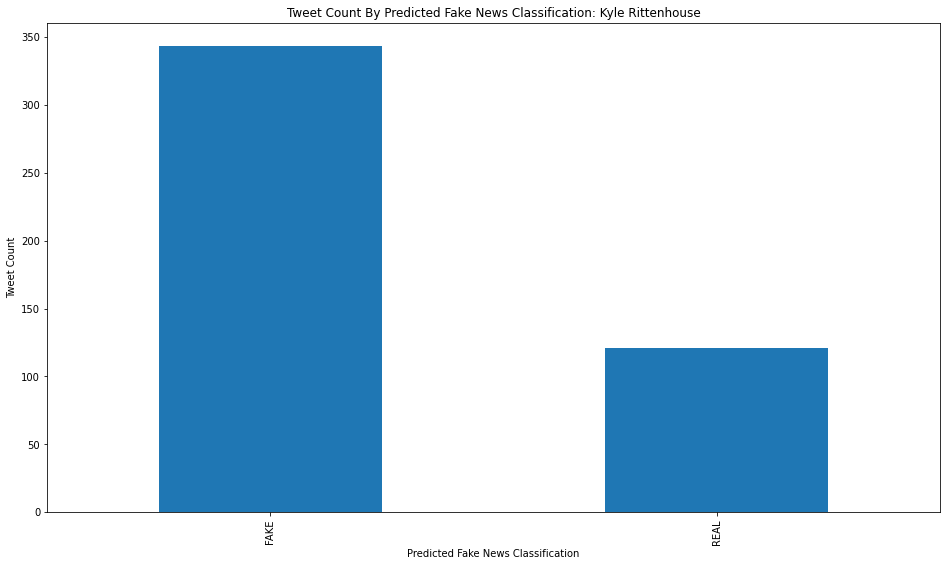

In [32]:
fake_news_text.fakenews.value_counts().plot.bar(title =('Tweet Count by Predicted Fake News Classification: ' + search_term).title(), xlabel = 'Predicted Fake News Classification', ylabel = "Tweet Count")

In [33]:
tweets_df.head()

,id,created_at,id_str,text,full_text,tweet_text,truncated,retweet_count,favorited,retweeted,possibly_sensitive,clean_tweet,emotion,emotion_confidence_confidence,sentiment,sentiment_confidence,sentiment_twitter,sentiment_twitter_confidence
0,1462726946740224000,2021-11-22 10:17:34+00:00,1462726946740224000,"RT @cooltxchick: I don’t know about you, but f...","RT @cooltxchick: I don’t know about you, but f...","RT @cooltxchick: I don’t know about you, but f...",False,342,False,False,<NA>,I do not know about you but for me Kyle and hi...,sadness,1.000000,neutral,0.512305,negative,1.000000
1,1462726928276856835,2021-11-22 10:17:30+00:00,1462726928276856835,RT @asymmetricinfo: The number of people outra...,RT @asymmetricinfo: The number of people outra...,RT @asymmetricinfo: The number of people outra...,False,763,False,False,<NA>,The number of people outraged by the idea that...,surprise,0.999759,pos,0.827644,negative,0.629275
2,1462726921704198148,2021-11-22 10:17:28+00:00,1462726921704198148,RT @ChuckCallesto: BREAKING REPORT: Defamation...,RT @ChuckCallesto: BREAKING REPORT: Defamation...,RT @ChuckCallesto: BREAKING REPORT: Defamation...,False,2524,False,False,<NA>,BREAKING REPO Defamation Attorney Todd McMurtr...,sadness,0.989748,neg,0.951887,neutral,0.589265
3,1462726921280798722,2021-11-22 10:17:28+00:00,1462726921280798722,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,False,446,False,False,<NA>,After Kyle Rittenhouse s verdict was announced...,surprise,0.999977,pos,0.999212,positive,1.000000
4,1462726916444762112,2021-11-22 10:17:27+00:00,1462726916444762112,"RT @gavinesler: My take on ""Missing the point ...","RT @gavinesler: My take on ""Missing the point ...","RT @gavinesler: My take on ""Missing the point ...",False,19,False,False,False,My take on Missing the point on Kyle Rittenhou...,sadness,0.949577,neg,0.998454,positive,1.000000


In [34]:
tweets_df = tweets_df.join(fake_news_text)
tweets_df.drop('document', inplace=True, axis =1)
tweets_df.head()

,id,created_at,id_str,text,full_text,tweet_text,truncated,retweet_count,favorited,retweeted,possibly_sensitive,clean_tweet,emotion,emotion_confidence_confidence,sentiment,sentiment_confidence,sentiment_twitter,sentiment_twitter_confidence,fakenews,fakenews_confidence_confidence
0,1462726946740224000,2021-11-22 10:17:34+00:00,1462726946740224000,"RT @cooltxchick: I don’t know about you, but f...","RT @cooltxchick: I don’t know about you, but f...","RT @cooltxchick: I don’t know about you, but f...",False,342,False,False,<NA>,I do not know about you but for me Kyle and hi...,sadness,1.000000,neutral,0.512305,negative,1.000000,FAKE,0.999984
1,1462726928276856835,2021-11-22 10:17:30+00:00,1462726928276856835,RT @asymmetricinfo: The number of people outra...,RT @asymmetricinfo: The number of people outra...,RT @asymmetricinfo: The number of people outra...,False,763,False,False,<NA>,The number of people outraged by the idea that...,surprise,0.999759,pos,0.827644,negative,0.629275,FAKE,0.777297
2,1462726921704198148,2021-11-22 10:17:28+00:00,1462726921704198148,RT @ChuckCallesto: BREAKING REPORT: Defamation...,RT @ChuckCallesto: BREAKING REPORT: Defamation...,RT @ChuckCallesto: BREAKING REPORT: Defamation...,False,2524,False,False,<NA>,BREAKING REPO Defamation Attorney Todd McMurtr...,sadness,0.989748,neg,0.951887,neutral,0.589265,FAKE,0.999850
3,1462726921280798722,2021-11-22 10:17:28+00:00,1462726921280798722,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,False,446,False,False,<NA>,After Kyle Rittenhouse s verdict was announced...,surprise,0.999977,pos,0.999212,positive,1.000000,REAL,0.999066
4,1462726916444762112,2021-11-22 10:17:27+00:00,1462726916444762112,"RT @gavinesler: My take on ""Missing the point ...","RT @gavinesler: My take on ""Missing the point ...","RT @gavinesler: My take on ""Missing the point ...",False,19,False,False,False,My take on Missing the point on Kyle Rittenhou...,sadness,0.949577,neg,0.998454,positive,1.000000,FAKE,0.999042


In [35]:
tweets_df[tweets_df['fakenews']=='REAL'].sample(5)

,id,created_at,id_str,text,full_text,tweet_text,truncated,retweet_count,favorited,retweeted,possibly_sensitive,clean_tweet,emotion,emotion_confidence_confidence,sentiment,sentiment_confidence,sentiment_twitter,sentiment_twitter_confidence,fakenews,fakenews_confidence_confidence
12,1462726847196803075,2021-11-22 10:17:11+00:00,1462726847196803075,RT @OccupyDemocrats: BREAKING: Colin Kaepernic...,RT @OccupyDemocrats: BREAKING: Colin Kaepernic...,RT @OccupyDemocrats: BREAKING: Colin Kaepernic...,False,933,False,False,<NA>,BREAKING Colin Kaepernick blasts Kyle Rittenho...,sadness,0.530830,neg,0.925211,positive,0.994543,REAL,0.996463
282,1462724913479909386,2021-11-22 10:09:30+00:00,1462724913479909386,RT @OccupyDemocrats: BREAKING: Colin Kaepernic...,<NA>,RT @OccupyDemocrats: BREAKING: Colin Kaepernic...,False,933,False,False,<NA>,BREAKING Colin Kaepernick blasts Kyle Rittenho...,sadness,0.530830,neg,0.925211,positive,0.994543,REAL,0.996463
51,1462726490215403520,2021-11-22 10:15:46+00:00,1462726490215403520,RT @SkyNewsAust: Sky News host @RitaPanahi say...,RT @SkyNewsAust: Sky News host @RitaPanahi say...,RT @SkyNewsAust: Sky News host @RitaPanahi say...,False,3,False,False,<NA>,Sky News host says much of the media in the Un...,fear,1.000000,pos,0.999948,negative,1.000000,REAL,0.995035
298,1462724851483897856,2021-11-22 10:09:15+00:00,1462724851483897856,RT @traceyecorder: We had to beg for the life ...,<NA>,RT @traceyecorder: We had to beg for the life ...,False,21989,False,False,<NA>,We had to beg for the life of Julius Jones yes...,sadness,0.998379,pos,0.999290,negative,0.997029,REAL,0.981083
376,1462724301132550146,2021-11-22 10:07:04+00:00,1462724301132550146,RT @lordvictor: So many people think self defe...,<NA>,RT @lordvictor: So many people think self defe...,False,18,False,False,<NA>,So many people think self defense is just a ne...,fear,1.000000,neg,0.999720,positive,1.000000,REAL,0.866698


## Spam Classification

In [36]:
 spam = nlu.load('en.classify.spam')
 spam_df = spam.predict(tweets_df.clean_tweet, output_level='document')
 spam_df.head()

classifierdl_use_spam download started this may take some time.
Approximate size to download 21.3 MB
[OK!]
tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


,document,spam,spam_confidence_confidence
0,I do not know about you but for me Kyle and hi...,ham,1.000000
1,The number of people outraged by the idea that...,ham,1.000000
2,BREAKING REPO Defamation Attorney Todd McMurtr...,ham,0.999982
3,After Kyle Rittenhouse s verdict was announced...,ham,1.000000
4,My take on Missing the point on Kyle Rittenhou...,ham,1.000000


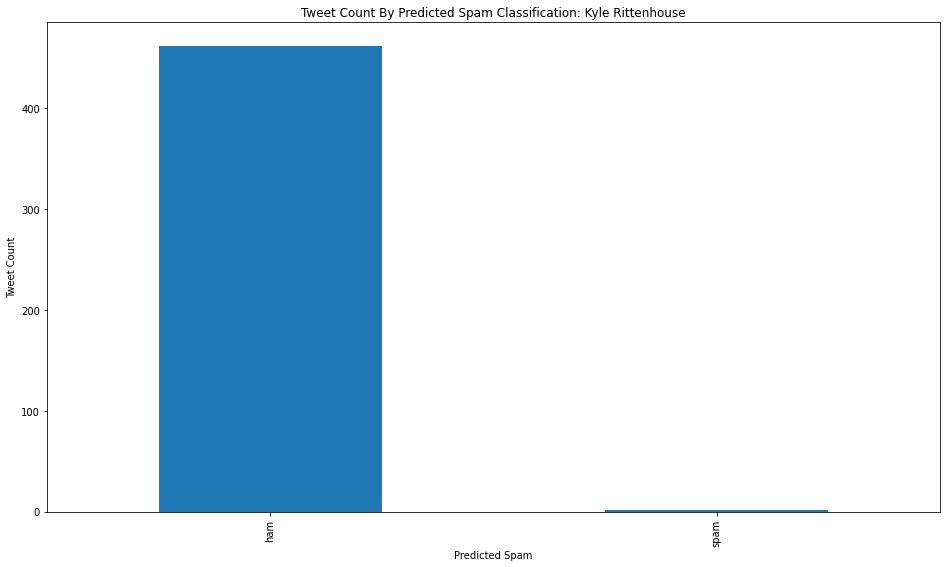

In [37]:
spam_df.spam.value_counts().plot.bar(title =('Tweet Count by Predicted Spam Classification: ' + search_term).title(), xlabel = 'Predicted Spam', ylabel = "Tweet Count")

In [38]:
tweets_df = tweets_df.join(spam_df)
tweets_df.drop('document', inplace=True, axis =1)
tweets_df.head()

,id,created_at,id_str,text,full_text,tweet_text,truncated,retweet_count,favorited,retweeted,possibly_sensitive,clean_tweet,emotion,emotion_confidence_confidence,sentiment,sentiment_confidence,sentiment_twitter,sentiment_twitter_confidence,fakenews,fakenews_confidence_confidence,spam,spam_confidence_confidence
0,1462726946740224000,2021-11-22 10:17:34+00:00,1462726946740224000,"RT @cooltxchick: I don’t know about you, but f...","RT @cooltxchick: I don’t know about you, but f...","RT @cooltxchick: I don’t know about you, but f...",False,342,False,False,<NA>,I do not know about you but for me Kyle and hi...,sadness,1.000000,neutral,0.512305,negative,1.000000,FAKE,0.999984,ham,1.000000
1,1462726928276856835,2021-11-22 10:17:30+00:00,1462726928276856835,RT @asymmetricinfo: The number of people outra...,RT @asymmetricinfo: The number of people outra...,RT @asymmetricinfo: The number of people outra...,False,763,False,False,<NA>,The number of people outraged by the idea that...,surprise,0.999759,pos,0.827644,negative,0.629275,FAKE,0.777297,ham,1.000000
2,1462726921704198148,2021-11-22 10:17:28+00:00,1462726921704198148,RT @ChuckCallesto: BREAKING REPORT: Defamation...,RT @ChuckCallesto: BREAKING REPORT: Defamation...,RT @ChuckCallesto: BREAKING REPORT: Defamation...,False,2524,False,False,<NA>,BREAKING REPO Defamation Attorney Todd McMurtr...,sadness,0.989748,neg,0.951887,neutral,0.589265,FAKE,0.999850,ham,0.999982
3,1462726921280798722,2021-11-22 10:17:28+00:00,1462726921280798722,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,False,446,False,False,<NA>,After Kyle Rittenhouse s verdict was announced...,surprise,0.999977,pos,0.999212,positive,1.000000,REAL,0.999066,ham,1.000000
4,1462726916444762112,2021-11-22 10:17:27+00:00,1462726916444762112,"RT @gavinesler: My take on ""Missing the point ...","RT @gavinesler: My take on ""Missing the point ...","RT @gavinesler: My take on ""Missing the point ...",False,19,False,False,False,My take on Missing the point on Kyle Rittenhou...,sadness,0.949577,neg,0.998454,positive,1.000000,FAKE,0.999042,ham,1.000000


In [41]:
tweets_df[tweets_df['spam']=='spam'].sample()

,id,created_at,id_str,text,full_text,tweet_text,truncated,retweet_count,favorited,retweeted,possibly_sensitive,clean_tweet,emotion,emotion_confidence_confidence,sentiment,sentiment_confidence,sentiment_twitter,sentiment_twitter_confidence,fakenews,fakenews_confidence_confidence,spam,spam_confidence_confidence
30,1462726667848278016,2021-11-22 10:16:28+00:00,1462726667848278016,"RT @WHSCI: @chipfranklin Residents of Kenosha,...","RT @WHSCI: @chipfranklin Residents of Kenosha,...","RT @WHSCI: @chipfranklin Residents of Kenosha,...",False,26,False,False,<NA>,Residents of Kenosha Wisconsin should jump on ...,joy,0.616268,neg,0.99957,positive,0.995603,FAKE,0.999995,spam,0.995809


## Toxic Classification

In [42]:
toxic = nlu.load('en.classify.toxic')
toxic_df = toxic.predict(tweets_df.clean_tweet, output_level='document')
toxic_df.head()

multiclassifierdl_use_toxic download started this may take some time.
Approximate size to download 11.6 MB
[OK!]
tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


,document,toxic,toxic_confidence_confidence
0,I do not know about you but for me Kyle and hi...,[toxic],[0.70546126]
1,The number of people outraged by the idea that...,NaN,NaN
2,BREAKING REPO Defamation Attorney Todd McMurtr...,NaN,NaN
3,After Kyle Rittenhouse s verdict was announced...,NaN,NaN
4,My take on Missing the point on Kyle Rittenhou...,NaN,NaN


In [43]:
tweets_df = tweets_df.join(toxic_df)
tweets_df.drop('document', inplace=True, axis =1)
tweets_df.head()

,id,created_at,id_str,text,full_text,tweet_text,truncated,retweet_count,favorited,retweeted,possibly_sensitive,clean_tweet,emotion,emotion_confidence_confidence,sentiment,sentiment_confidence,sentiment_twitter,sentiment_twitter_confidence,fakenews,fakenews_confidence_confidence,spam,spam_confidence_confidence,toxic,toxic_confidence_confidence
0,1462726946740224000,2021-11-22 10:17:34+00:00,1462726946740224000,"RT @cooltxchick: I don’t know about you, but f...","RT @cooltxchick: I don’t know about you, but f...","RT @cooltxchick: I don’t know about you, but f...",False,342,False,False,<NA>,I do not know about you but for me Kyle and hi...,sadness,1.000000,neutral,0.512305,negative,1.000000,FAKE,0.999984,ham,1.000000,[toxic],[0.70546126]
1,1462726928276856835,2021-11-22 10:17:30+00:00,1462726928276856835,RT @asymmetricinfo: The number of people outra...,RT @asymmetricinfo: The number of people outra...,RT @asymmetricinfo: The number of people outra...,False,763,False,False,<NA>,The number of people outraged by the idea that...,surprise,0.999759,pos,0.827644,negative,0.629275,FAKE,0.777297,ham,1.000000,NaN,NaN
2,1462726921704198148,2021-11-22 10:17:28+00:00,1462726921704198148,RT @ChuckCallesto: BREAKING REPORT: Defamation...,RT @ChuckCallesto: BREAKING REPORT: Defamation...,RT @ChuckCallesto: BREAKING REPORT: Defamation...,False,2524,False,False,<NA>,BREAKING REPO Defamation Attorney Todd McMurtr...,sadness,0.989748,neg,0.951887,neutral,0.589265,FAKE,0.999850,ham,0.999982,NaN,NaN
3,1462726921280798722,2021-11-22 10:17:28+00:00,1462726921280798722,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,False,446,False,False,<NA>,After Kyle Rittenhouse s verdict was announced...,surprise,0.999977,pos,0.999212,positive,1.000000,REAL,0.999066,ham,1.000000,NaN,NaN
4,1462726916444762112,2021-11-22 10:17:27+00:00,1462726916444762112,"RT @gavinesler: My take on ""Missing the point ...","RT @gavinesler: My take on ""Missing the point ...","RT @gavinesler: My take on ""Missing the point ...",False,19,False,False,False,My take on Missing the point on Kyle Rittenhou...,sadness,0.949577,neg,0.998454,positive,1.000000,FAKE,0.999042,ham,1.000000,NaN,NaN


In [44]:
tweets_df['toxic'] = tweets_df['toxic'].replace(np.nan, 'non-rated')
tweets_df.head()

,id,created_at,id_str,text,full_text,tweet_text,truncated,retweet_count,favorited,retweeted,possibly_sensitive,clean_tweet,emotion,emotion_confidence_confidence,sentiment,sentiment_confidence,sentiment_twitter,sentiment_twitter_confidence,fakenews,fakenews_confidence_confidence,spam,spam_confidence_confidence,toxic,toxic_confidence_confidence
0,1462726946740224000,2021-11-22 10:17:34+00:00,1462726946740224000,"RT @cooltxchick: I don’t know about you, but f...","RT @cooltxchick: I don’t know about you, but f...","RT @cooltxchick: I don’t know about you, but f...",False,342,False,False,<NA>,I do not know about you but for me Kyle and hi...,sadness,1.000000,neutral,0.512305,negative,1.000000,FAKE,0.999984,ham,1.000000,[toxic],[0.70546126]
1,1462726928276856835,2021-11-22 10:17:30+00:00,1462726928276856835,RT @asymmetricinfo: The number of people outra...,RT @asymmetricinfo: The number of people outra...,RT @asymmetricinfo: The number of people outra...,False,763,False,False,<NA>,The number of people outraged by the idea that...,surprise,0.999759,pos,0.827644,negative,0.629275,FAKE,0.777297,ham,1.000000,non-rated,NaN
2,1462726921704198148,2021-11-22 10:17:28+00:00,1462726921704198148,RT @ChuckCallesto: BREAKING REPORT: Defamation...,RT @ChuckCallesto: BREAKING REPORT: Defamation...,RT @ChuckCallesto: BREAKING REPORT: Defamation...,False,2524,False,False,<NA>,BREAKING REPO Defamation Attorney Todd McMurtr...,sadness,0.989748,neg,0.951887,neutral,0.589265,FAKE,0.999850,ham,0.999982,non-rated,NaN
3,1462726921280798722,2021-11-22 10:17:28+00:00,1462726921280798722,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,False,446,False,False,<NA>,After Kyle Rittenhouse s verdict was announced...,surprise,0.999977,pos,0.999212,positive,1.000000,REAL,0.999066,ham,1.000000,non-rated,NaN
4,1462726916444762112,2021-11-22 10:17:27+00:00,1462726916444762112,"RT @gavinesler: My take on ""Missing the point ...","RT @gavinesler: My take on ""Missing the point ...","RT @gavinesler: My take on ""Missing the point ...",False,19,False,False,False,My take on Missing the point on Kyle Rittenhou...,sadness,0.949577,neg,0.998454,positive,1.000000,FAKE,0.999042,ham,1.000000,non-rated,NaN


In [45]:
toxic_df = toxic_df.explode('toxic')
toxic_df['toxic'] = toxic_df['toxic'].replace(np.nan, 'non-rated')
toxic_df.head()

,document,toxic,toxic_confidence_confidence
0,I do not know about you but for me Kyle and hi...,toxic,[0.70546126]
1,The number of people outraged by the idea that...,non-rated,NaN
2,BREAKING REPO Defamation Attorney Todd McMurtr...,non-rated,NaN
3,After Kyle Rittenhouse s verdict was announced...,non-rated,NaN
4,My take on Missing the point on Kyle Rittenhou...,non-rated,NaN


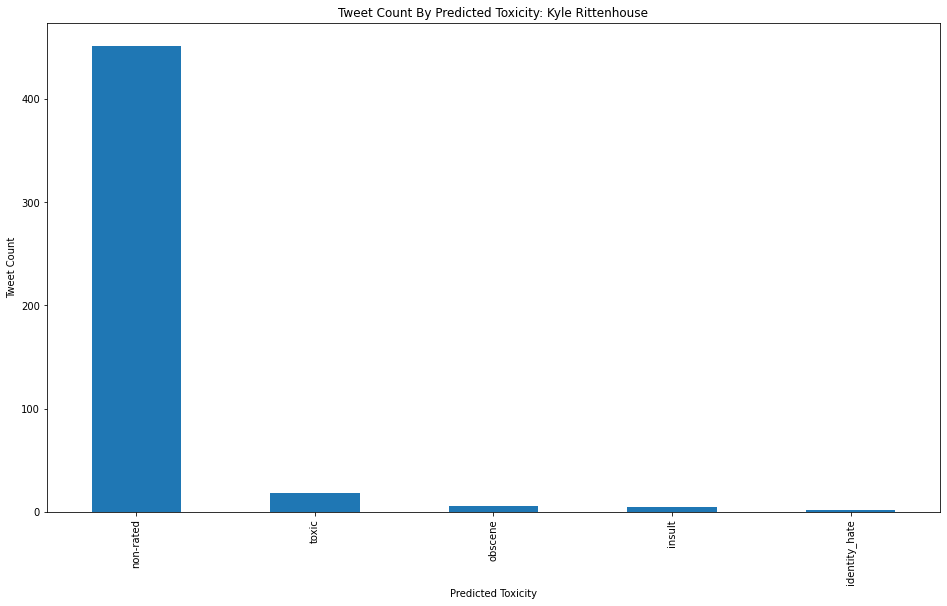

In [46]:
toxic_df.toxic.value_counts().plot.bar(title =('Tweet Count by Predicted Toxicity: ' + search_term).title(), xlabel = 'Predicted Toxicity', ylabel = "Tweet Count")

In [47]:
toxic_df[toxic_df['toxic']=='toxic'].sample()

,document,toxic,toxic_confidence_confidence
113,yle rittenhouse more like kyle gets no bitches...,toxic,"[0.6879002, 0.6879002]"


## Sarcasm Classification

In [48]:
sarcasm = nlu.load('en.classify.sarcasm')
sarcasm_df = sarcasm.predict(tweets_df.clean_tweet, output_level='document')
sarcasm_df.head()

classifierdl_use_sarcasm download started this may take some time.
Approximate size to download 21.3 MB
[OK!]
tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


,document,sarcasm,sarcasm_confidence_confidence
0,I do not know about you but for me Kyle and hi...,normal,0.999591
1,The number of people outraged by the idea that...,normal,0.980689
2,BREAKING REPO Defamation Attorney Todd McMurtr...,normal,0.999986
3,After Kyle Rittenhouse s verdict was announced...,normal,0.999780
4,My take on Missing the point on Kyle Rittenhou...,normal,0.998927


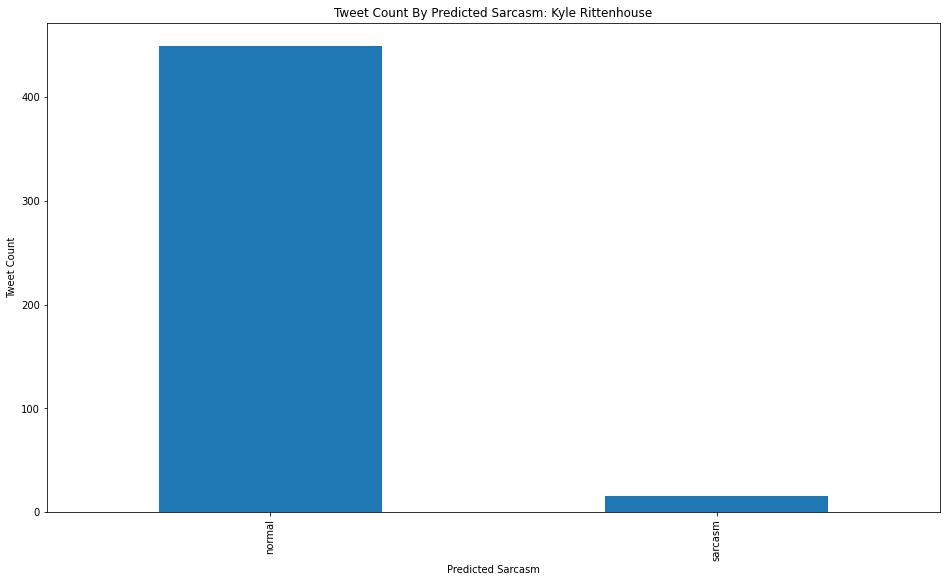

In [49]:
sarcasm_df.sarcasm.value_counts().plot.bar(title =('Tweet Count by Predicted Sarcasm: ' + search_term).title(), xlabel = 'Predicted Sarcasm', ylabel = "Tweet Count")

In [50]:
tweets_df = tweets_df.join(sarcasm_df)
tweets_df.drop('document', inplace=True, axis =1)
tweets_df.head()

,id,created_at,id_str,text,full_text,tweet_text,truncated,retweet_count,favorited,retweeted,possibly_sensitive,clean_tweet,emotion,emotion_confidence_confidence,sentiment,sentiment_confidence,sentiment_twitter,sentiment_twitter_confidence,fakenews,fakenews_confidence_confidence,spam,spam_confidence_confidence,toxic,toxic_confidence_confidence,sarcasm,sarcasm_confidence_confidence
0,1462726946740224000,2021-11-22 10:17:34+00:00,1462726946740224000,"RT @cooltxchick: I don’t know about you, but f...","RT @cooltxchick: I don’t know about you, but f...","RT @cooltxchick: I don’t know about you, but f...",False,342,False,False,<NA>,I do not know about you but for me Kyle and hi...,sadness,1.000000,neutral,0.512305,negative,1.000000,FAKE,0.999984,ham,1.000000,[toxic],[0.70546126],normal,0.999591
1,1462726928276856835,2021-11-22 10:17:30+00:00,1462726928276856835,RT @asymmetricinfo: The number of people outra...,RT @asymmetricinfo: The number of people outra...,RT @asymmetricinfo: The number of people outra...,False,763,False,False,<NA>,The number of people outraged by the idea that...,surprise,0.999759,pos,0.827644,negative,0.629275,FAKE,0.777297,ham,1.000000,non-rated,NaN,normal,0.980689
2,1462726921704198148,2021-11-22 10:17:28+00:00,1462726921704198148,RT @ChuckCallesto: BREAKING REPORT: Defamation...,RT @ChuckCallesto: BREAKING REPORT: Defamation...,RT @ChuckCallesto: BREAKING REPORT: Defamation...,False,2524,False,False,<NA>,BREAKING REPO Defamation Attorney Todd McMurtr...,sadness,0.989748,neg,0.951887,neutral,0.589265,FAKE,0.999850,ham,0.999982,non-rated,NaN,normal,0.999986
3,1462726921280798722,2021-11-22 10:17:28+00:00,1462726921280798722,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,RT @MrAndyNgo: After Kyle #Rittenhouse's verdi...,False,446,False,False,<NA>,After Kyle Rittenhouse s verdict was announced...,surprise,0.999977,pos,0.999212,positive,1.000000,REAL,0.999066,ham,1.000000,non-rated,NaN,normal,0.999780
4,1462726916444762112,2021-11-22 10:17:27+00:00,1462726916444762112,"RT @gavinesler: My take on ""Missing the point ...","RT @gavinesler: My take on ""Missing the point ...","RT @gavinesler: My take on ""Missing the point ...",False,19,False,False,False,My take on Missing the point on Kyle Rittenhou...,sadness,0.949577,neg,0.998454,positive,1.000000,FAKE,0.999042,ham,1.000000,non-rated,NaN,normal,0.998927


In [51]:
tweets_df[tweets_df['sarcasm']=='sarcasm'].sample(5)

,id,created_at,id_str,text,full_text,tweet_text,truncated,retweet_count,favorited,retweeted,possibly_sensitive,clean_tweet,emotion,emotion_confidence_confidence,sentiment,sentiment_confidence,sentiment_twitter,sentiment_twitter_confidence,fakenews,fakenews_confidence_confidence,spam,spam_confidence_confidence,toxic,toxic_confidence_confidence,sarcasm,sarcasm_confidence_confidence
89,1462726272635703300,2021-11-22 10:14:54+00:00,1462726272635703300,RT @SkyNewsAust: Sky News host @RitaPanahi say...,RT @SkyNewsAust: Sky News host @RitaPanahi say...,RT @SkyNewsAust: Sky News host @RitaPanahi say...,False,3,False,False,<NA>,Sky News host says much of the media in the Un...,fear,1.000000,pos,0.999948,negative,1.000000,REAL,0.995035,ham,0.999992,non-rated,NaN,sarcasm,0.593877
111,1462726119866736649,2021-11-22 10:14:17+00:00,1462726119866736649,RT @TheRightMelissa: Video of Kyle Rittenhouse...,<NA>,RT @TheRightMelissa: Video of Kyle Rittenhouse...,False,5935,False,False,<NA>,Video of Kyle Rittenhouse peacefully walking w...,sadness,0.999988,pos,0.918539,negative,1.000000,FAKE,0.999891,ham,1.000000,non-rated,NaN,sarcasm,0.772251
271,1462724978252468226,2021-11-22 10:09:45+00:00,1462724978252468226,RT @punishedmother: Conservatives losing their...,<NA>,RT @punishedmother: Conservatives losing their...,False,53,False,False,<NA>,Conservatives losing their shit over Kyle Ritt...,sadness,0.998676,neg,0.983373,negative,0.797024,REAL,0.980479,ham,1.000000,non-rated,NaN,sarcasm,0.519318
246,1462725072389562370,2021-11-22 10:10:08+00:00,1462725072389562370,RT @SkyNewsAust: Sky News host @RitaPanahi say...,<NA>,RT @SkyNewsAust: Sky News host @RitaPanahi say...,False,3,False,False,<NA>,Sky News host says much of the media in the Un...,fear,1.000000,pos,0.999948,negative,1.000000,REAL,0.995035,ham,0.999992,non-rated,NaN,sarcasm,0.593877
456,1462723768627965955,2021-11-22 10:04:57+00:00,1462723768627965955,RT @TheRightMelissa: Video of Kyle Rittenhouse...,<NA>,RT @TheRightMelissa: Video of Kyle Rittenhouse...,False,5935,False,False,<NA>,Video of Kyle Rittenhouse peacefully walking w...,sadness,0.999988,pos,0.918539,negative,1.000000,FAKE,0.999891,ham,1.000000,non-rated,NaN,sarcasm,0.772251


## Keyword Extraction

In [52]:
yake = nlu.load('yake')
yake['yake'].setThreshold(.50)  
yake_df = yake.predict(tweets_df.clean_tweet)
yake_df.head()

sentence_detector_dl download started this may take some time.
Approximate size to download 354.6 KB
[OK!]


,document,keywords,keywords_confidence
0,I do not know about you but for me Kyle and hi...,NaN,NaN
1,The number of people outraged by the idea that...,kyle rittenhouse,0.22795696529154544
1,The number of people outraged by the idea that...,rittenhouse deserved,0.3419724473611488
1,The number of people outraged by the idea that...,kyle rittenhouse deserved,0.20941475449605412
2,BREAKING REPO Defamation Attorney Todd McMurtr...,ritten,0.26804494089513314


In [53]:
# yake.print_info()
# yake['yake'].setMinNGrams(1)
# yake['yake'].setMaxNGrams(3)
# yake_text = yake.predict(text.cleanText)
# yake_text

In [55]:
# yake_text.keywords.value_counts()[:50].plot.bar()

#If df had a column with multiple keywords use:
# yake_text.explode('keywords).keywords.value_counts()[0:100].plot.bar()

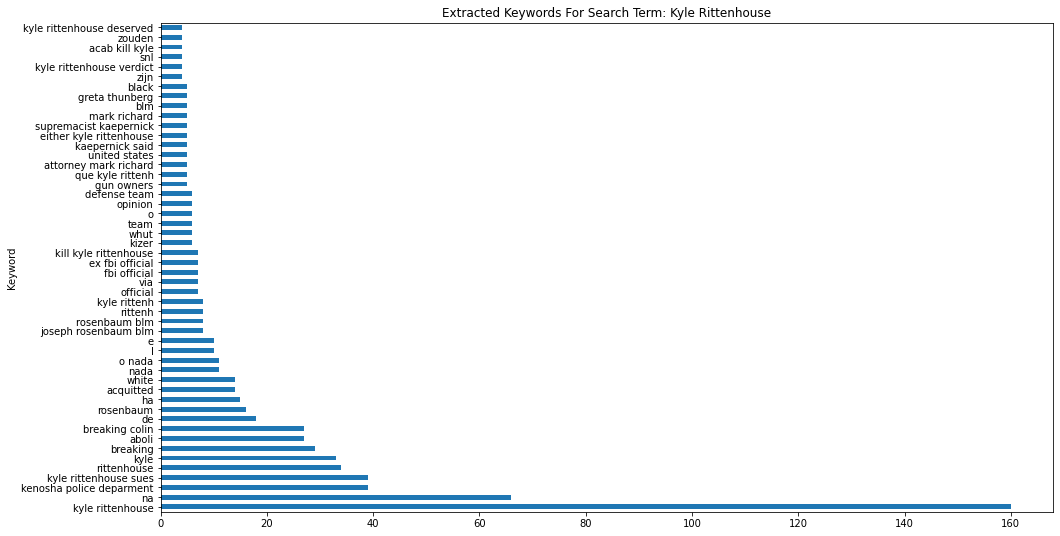

In [56]:
yake_df.keywords.value_counts()[0:50].plot.barh(title =('Extracted Keywords for Search Term: ' + search_term).title(), xlabel = 'Keyword', ylabel = "Tweet Count")

## Named Entity Recognition

In [57]:
ner = nlu.load('ner')
ner_df = ner.predict(tweets_df.clean_tweet)
ner_df.head()

onto_recognize_entities_sm download started this may take some time.
Approx size to download 160.1 MB
[OK!]


,document,entities,entities_class,entities_confidence
0,I do not know about you but for me Kyle and hi...,Kyle,PERSON,0.992
0,I do not know about you but for me Kyle and hi...,Rittenhouse Rehab Remorse Tour,WORK_OF_ART,0.47665
1,The number of people outraged by the idea that...,Kyle Rittenhouse,PERSON,0.9656
2,BREAKING REPO Defamation Attorney Todd McMurtr...,Todd McMurtry,PERSON,0.9806
2,BREAKING REPO Defamation Attorney Todd McMurtr...,Sandmann,PERSON,0.746


In [58]:
ner_df.groupby(['entities_class'])['entities'].count().sort_values(ascending=False)

entities_class
PERSON         587
ORG            136
GPE             94
CARDINAL        94
DATE            25
NORP            22
LOC             14
WORK_OF_ART     12
FAC             12
TIME            10
QUANTITY         2
MONEY            2
LAW              2
ORDINAL          1
Name: entities, dtype: int64

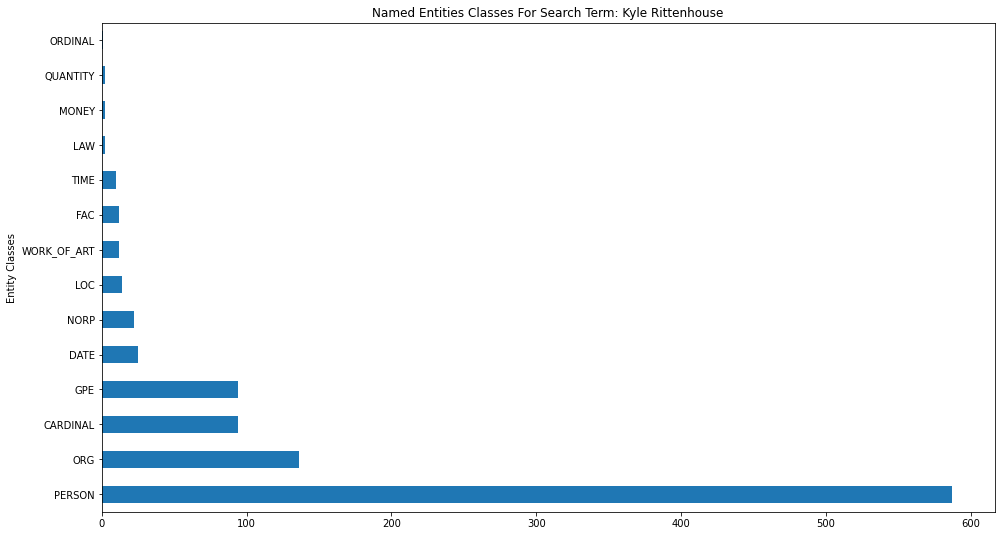

In [59]:
ner_df.entities_class.value_counts()[0:50].plot.barh(title =('Named Entities Classes for Search Term: ' + search_term).title(), xlabel = 'Entity Classes', ylabel = "Tweet Count")

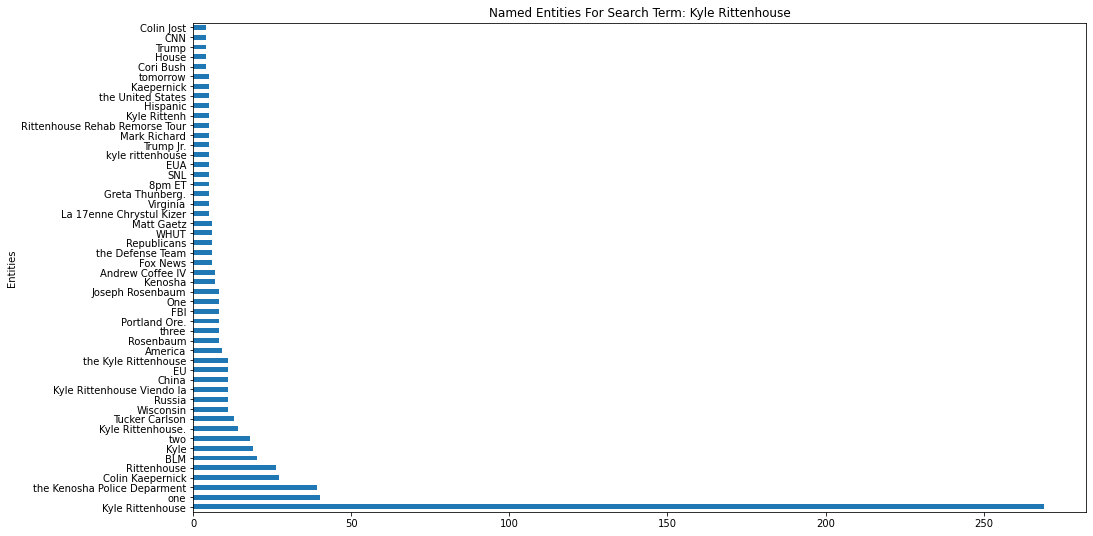

In [60]:
ner_df.entities.value_counts()[0:50].plot.barh(title =('Named Entities for Search Term: ' + search_term).title(), xlabel = 'Entities', ylabel = "Tweet Count")

In [67]:
# Pickle Files
dt_string = datetime.now().strftime("%d%m%Y-%H%M%S")
dt_string
path = '/content/drive/MyDrive/DU/tools1/myHomework/' + search_term + dt_string +'.csv'
tweets_df.to_csv(path)